In [165]:
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
from sklearn import metrics
import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [149]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample= pd.read_csv("submit.csv",header=None)

In [75]:
train

,id,loan_amnt,term,interest_rate,grade,employment_length,purpose,credit_score,application_type,loan_status
0,0,609.296068,3 years,8.421982,A5,0 years,debt_consolidation,714.061803,Individual,FullyPaid
1,1,1183.266999,5 years,10.286776,B1,10 years,credit_card,697.706701,Individual,ChargedOff
2,2,695.783256,3 years,14.723425,C2,1 year,debt_consolidation,656.419357,Individual,FullyPaid
3,3,738.392546,3 years,14.260708,C1,0 years,credit_card,657.906852,Individual,FullyPaid
4,4,1642.400654,5 years,25.217452,E5,10 years,debt_consolidation,662.972297,Individual,FullyPaid
...,...,...,...,...,...,...,...,...,...,...
242145,242145,2427.939262,3 years,13.673803,B4,8 years,debt_consolidation,657.206417,Individual,FullyPaid
242146,242146,1224.346665,3 years,11.793595,B3,10 years,debt_consolidation,699.763028,Individual,ChargedOff
242147,242147,2089.513458,3 years,8.218123,A4,1 year,other,724.556339,Individual,FullyPaid
242148,242148,3459.367114,3 years,14.875958,C2,9 years,debt_consolidation,688.249378,Individual,FullyPaid


In [76]:
test

,id,loan_amnt,term,interest_rate,grade,employment_length,purpose,credit_score,application_type
0,242150,1161.830205,3 years,13.105362,C1,10 years,credit_card,682.016083,Individual
1,242151,2257.465815,5 years,14.196200,C5,10 years,debt_consolidation,668.240313,Individual
2,242152,2182.137002,3 years,8.307772,A5,10 years,credit_card,703.277694,Individual
3,242153,520.284912,3 years,6.956504,A2,7 years,debt_consolidation,731.138779,Individual
4,242154,2303.349549,3 years,11.658497,B3,6 years,debt_consolidation,698.368991,Individual
...,...,...,...,...,...,...,...,...,...
26895,269045,1169.767130,3 years,13.609916,B4,1 year,credit_card,656.939828,Individual
26896,269046,2235.153322,3 years,7.248690,A2,10 years,credit_card,765.770393,Individual
26897,269047,3272.971410,3 years,9.957002,B4,6 years,debt_consolidation,793.887391,Individual
26898,269048,1607.397707,3 years,10.892554,B3,10 years,debt_consolidation,658.815541,Individual


## データの確認と前処理

 

In [4]:
import seaborn as sns

<AxesSubplot:>

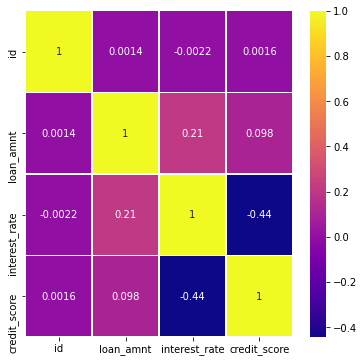

In [5]:
plt.figure(figsize=(6, 6)) #heatmap size
sns.heatmap(train.corr(), annot=True, cmap='plasma', linewidths=.5) 

In [121]:
corr_matrix = train.corr()

<AxesSubplot:>

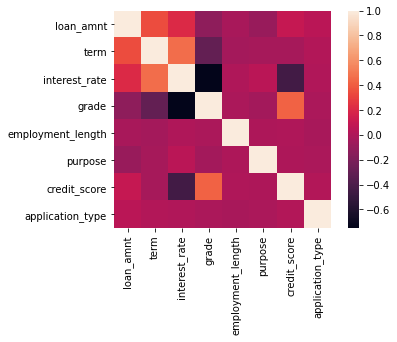

In [122]:

sns.heatmap(corr_matrix,
            square=True,
            xticklabels=corr_matrix.columns.values,
            yticklabels=corr_matrix.columns.values)

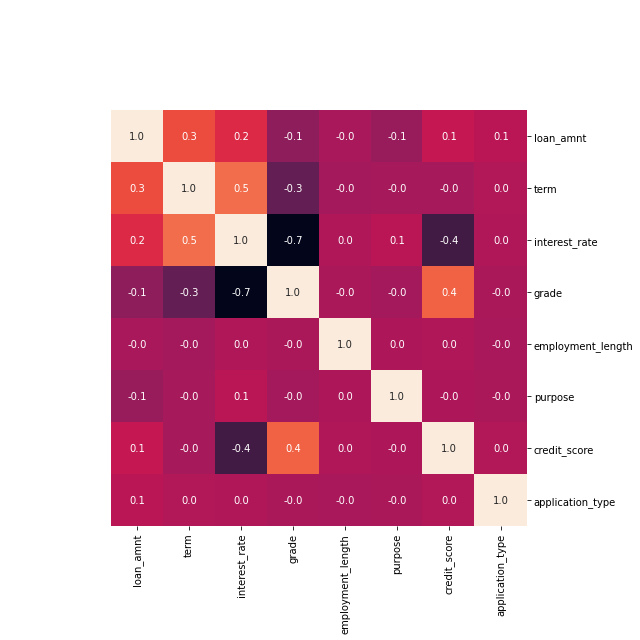

In [123]:
cm = sns.clustermap(corr_matrix, annot=True, figsize=(9, 9), col_cluster=False, row_cluster=False, fmt="1.1f")
cm.cax.set_visible(False)
display()

array([[<AxesSubplot:title={'center':'loan_amnt'}>,
        <AxesSubplot:title={'center':'term'}>,
        <AxesSubplot:title={'center':'interest_rate'}>],
       [<AxesSubplot:title={'center':'grade'}>,
        <AxesSubplot:title={'center':'employment_length'}>,
        <AxesSubplot:title={'center':'purpose'}>],
       [<AxesSubplot:title={'center':'credit_score'}>,
        <AxesSubplot:title={'center':'application_type'}>,
        <AxesSubplot:>]], dtype=object)

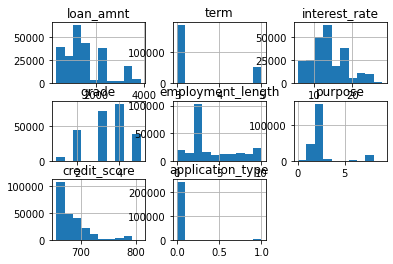

In [141]:
train.hist()

In [4]:
import pandas_profiling as pdp

In [5]:
html = pdp.ProfileReport(train)
html.to_file(output_file='dump.html')

In [6]:
train.describe()

,id,loan_amnt,interest_rate,credit_score
count,242150.00000,242150.000000,242150.000000,242150.000000
mean,121074.50000,1520.389009,13.801496,683.575024
std,69902.82818,830.250197,4.588924,29.554795
min,0.00000,323.797279,5.704849,655.424269
25%,60537.25000,761.954545,10.876086,659.531106
50%,121074.50000,1212.680586,13.543833,678.672563
75%,181611.75000,2152.213330,17.172395,698.591960
max,242149.00000,3851.867974,27.980604,808.551641


In [7]:
train.isnull().sum()

id                   0
loan_amnt            0
term                 0
interest_rate        0
grade                0
employment_length    0
purpose              0
credit_score         0
application_type     0
loan_status          0
dtype: int64

In [8]:
train["application_type"].value_counts()

Individual    240368
Joint App       1782
Name: application_type, dtype: int64

In [9]:
train["purpose"].value_counts()

debt_consolidation    160207
credit_card            48900
other                  17633
home_improvement        7686
car                     3855
medical                 3154
small_business           449
major_purchase           262
house                      4
Name: purpose, dtype: int64

In [10]:
train["grade"].value_counts()

C4    18936
B4    18409
C1    16767
B2    16357
B3    16058
B1    15484
B5    15163
C2    13917
C5    11420
A5    10785
D1    10464
C3    10266
D4     9828
A4     9441
D2     8823
D3     8387
D5     6866
A3     6532
A1     5764
A2     5749
E2     2835
E4     2301
E1      640
E5      535
E3      416
F5        4
F3        3
Name: grade, dtype: int64

In [81]:
train["term"].value_counts()

3 years    189887
5 years     52263
Name: term, dtype: int64

In [82]:
train["employment_length"].value_counts()

10 years    103339
0 years      19373
9 years      18374
2 years      15783
1 year       15141
6 years      14815
4 years      13418
5 years      12812
7 years      12673
3 years      11295
8 years       5127
Name: employment_length, dtype: int64

In [17]:
train["loan_status"].value_counts()

FullyPaid     199794
ChargedOff     42356
Name: loan_status, dtype: int64

In [150]:
train.loc[train["loan_status"]=="ChargedOff","loan_status"]=0
train.loc[train["loan_status"]=="FullyPaid","loan_status"]=1
    

<AxesSubplot:xlabel='grade', ylabel='count'>

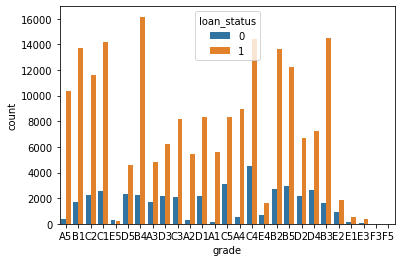

In [147]:
sns.countplot(x="grade",hue="loan_status",data=train)

<AxesSubplot:xlabel='application_type', ylabel='count'>

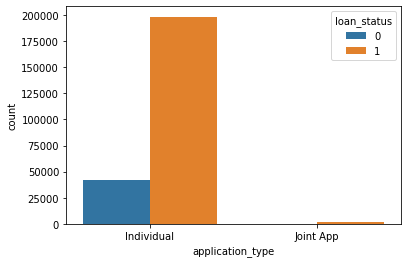

In [148]:
sns.countplot(x="application_type",hue="loan_status",data=train)

In [40]:
train.groupby(["grade","loan_status"]).count()["id"]

grade  loan_status
A1     0                140
       1               5624
A2     0                319
       1               5430
A3     0               1711
       1               4821
A4     0                520
       1               8921
A5     0                398
       1              10387
B1     0               1737
       1              13747
B2     0               2688
       1              13669
B3     0               1589
       1              14469
B4     0               2255
       1              16154
B5     0               2950
       1              12213
C1     0               2593
       1              14174
C2     0               2274
       1              11643
C3     0               2064
       1               8202
C4     0               4488
       1              14448
C5     0               3124
       1               8296
D1     0               2135
       1               8329
D2     0               2149
       1               6674
D3     0               2201
 

In [41]:
train.groupby(["application_type","loan_status"]).count()["id"]

application_type  loan_status
Individual        0               42084
                  1              198284
Joint App         0                 272
                  1                1510
Name: id, dtype: int64

In [42]:
train.groupby(["purpose","loan_status"]).count()["id"]

purpose             loan_status
car                 0                 486
                    1                3369
credit_card         0                6905
                    1               41995
debt_consolidation  0               29923
                    1              130284
home_improvement    0                 972
                    1                6714
house               1                   4
major_purchase      0                 127
                    1                 135
medical             0                 857
                    1                2297
other               0                3000
                    1               14633
small_business      0                  86
                    1                 363
Name: id, dtype: int64

In [83]:
train.groupby(["employment_length","loan_status"]).count()["id"]

employment_length  loan_status
0 years            ChargedOff      3995
                   FullyPaid      15378
1 year             ChargedOff      2380
                   FullyPaid      12761
10 years           ChargedOff     19060
                   FullyPaid      84279
2 years            ChargedOff      3063
                   FullyPaid      12720
3 years            ChargedOff      1938
                   FullyPaid       9357
4 years            ChargedOff      1498
                   FullyPaid      11920
5 years            ChargedOff      2047
                   FullyPaid      10765
6 years            ChargedOff      2235
                   FullyPaid      12580
7 years            ChargedOff      1778
                   FullyPaid      10895
8 years            ChargedOff       944
                   FullyPaid       4183
9 years            ChargedOff      3418
                   FullyPaid      14956
Name: id, dtype: int64

In [87]:
for i in range(len(train)):  ## 処理重すぎて分ける
    train["term"]=train["term"][i].split(" ")[0]

'3'

In [85]:
train

,id,loan_amnt,term,interest_rate,grade,employment_length,purpose,credit_score,application_type,loan_status
0,0,609.296068,3 years,8.421982,A5,0 years,debt_consolidation,714.061803,Individual,FullyPaid
1,1,1183.266999,5 years,10.286776,B1,10 years,credit_card,697.706701,Individual,ChargedOff
2,2,695.783256,3 years,14.723425,C2,1 year,debt_consolidation,656.419357,Individual,FullyPaid
3,3,738.392546,3 years,14.260708,C1,0 years,credit_card,657.906852,Individual,FullyPaid
4,4,1642.400654,5 years,25.217452,E5,10 years,debt_consolidation,662.972297,Individual,FullyPaid
...,...,...,...,...,...,...,...,...,...,...
242145,242145,2427.939262,3 years,13.673803,B4,8 years,debt_consolidation,657.206417,Individual,FullyPaid
242146,242146,1224.346665,3 years,11.793595,B3,10 years,debt_consolidation,699.763028,Individual,ChargedOff
242147,242147,2089.513458,3 years,8.218123,A4,1 year,other,724.556339,Individual,FullyPaid
242148,242148,3459.367114,3 years,14.875958,C2,9 years,debt_consolidation,688.249378,Individual,FullyPaid


In [ ]:
for i in range(len(train)):
     train["employment_length"] = train["employment_length"][i].split(" ")[0]

In [ ]:
for i in range(len(test)):
    test["term"]=test["term"][i].split(" ")[0]
    

In [70]:
for i in range(len(test)):
    test["employment_length"] = test["employment_length"][i].split(" ")[0]

,id,loan_amnt,term,interest_rate,grade,employment_length,purpose,credit_score,application_type,loan_status
0,0,609.296068,3 years,8.421982,A5,0 years,debt_consolidation,714.061803,Individual,FullyPaid
1,1,1183.266999,5 years,10.286776,B1,10 years,credit_card,697.706701,Individual,ChargedOff
2,2,695.783256,3 years,14.723425,C2,1 year,debt_consolidation,656.419357,Individual,FullyPaid
3,3,738.392546,3 years,14.260708,C1,0 years,credit_card,657.906852,Individual,FullyPaid
4,4,1642.400654,5 years,25.217452,E5,10 years,debt_consolidation,662.972297,Individual,FullyPaid
...,...,...,...,...,...,...,...,...,...,...
242145,242145,2427.939262,3 years,13.673803,B4,8 years,debt_consolidation,657.206417,Individual,FullyPaid
242146,242146,1224.346665,3 years,11.793595,B3,10 years,debt_consolidation,699.763028,Individual,ChargedOff
242147,242147,2089.513458,3 years,8.218123,A4,1 year,other,724.556339,Individual,FullyPaid
242148,242148,3459.367114,3 years,14.875958,C2,9 years,debt_consolidation,688.249378,Individual,FullyPaid


In [151]:
grade_mapping = {
    'A5':5,
    'A4':5,
    'A3':5,
    'A2':5,
    'A1':5,
    'B5':4,
    'B4':4,
    'B3':4,
    'B2':4,
    'B1':4,
    'C5':3,
    'C4':3,
    'C3':3,
    'C2':3,
    'C1':3,
    'D5':2,
    'D4':2,
    'D3':2,
    'D2':2,
    'D1':2,
    'E5':1,
    'E4':1,
    'E3':1,
    'E2':1,
    'E1':1,
    
    
    
}
train['grade'] = train['grade'].map(grade_mapping)
test['grade']=test['grade'].map(grade_mapping)

In [152]:
train

,id,loan_amnt,term,interest_rate,grade,employment_length,purpose,credit_score,application_type,loan_status
0,0,609.296068,3 years,8.421982,5.0,0 years,debt_consolidation,714.061803,Individual,1
1,1,1183.266999,5 years,10.286776,4.0,10 years,credit_card,697.706701,Individual,0
2,2,695.783256,3 years,14.723425,3.0,1 year,debt_consolidation,656.419357,Individual,1
3,3,738.392546,3 years,14.260708,3.0,0 years,credit_card,657.906852,Individual,1
4,4,1642.400654,5 years,25.217452,1.0,10 years,debt_consolidation,662.972297,Individual,1
...,...,...,...,...,...,...,...,...,...,...
242145,242145,2427.939262,3 years,13.673803,4.0,8 years,debt_consolidation,657.206417,Individual,1
242146,242146,1224.346665,3 years,11.793595,4.0,10 years,debt_consolidation,699.763028,Individual,0
242147,242147,2089.513458,3 years,8.218123,5.0,1 year,other,724.556339,Individual,1
242148,242148,3459.367114,3 years,14.875958,3.0,9 years,debt_consolidation,688.249378,Individual,1


In [153]:
term_mapping ={
    '3 years': 3,
    '5 years':5
}
train['term'] = train['term'].map(term_mapping)
test['term'] = test['term'].map(term_mapping)

In [154]:
test

,id,loan_amnt,term,interest_rate,grade,employment_length,purpose,credit_score,application_type
0,242150,1161.830205,3,13.105362,3,10 years,credit_card,682.016083,Individual
1,242151,2257.465815,5,14.196200,3,10 years,debt_consolidation,668.240313,Individual
2,242152,2182.137002,3,8.307772,5,10 years,credit_card,703.277694,Individual
3,242153,520.284912,3,6.956504,5,7 years,debt_consolidation,731.138779,Individual
4,242154,2303.349549,3,11.658497,4,6 years,debt_consolidation,698.368991,Individual
...,...,...,...,...,...,...,...,...,...
26895,269045,1169.767130,3,13.609916,4,1 year,credit_card,656.939828,Individual
26896,269046,2235.153322,3,7.248690,5,10 years,credit_card,765.770393,Individual
26897,269047,3272.971410,3,9.957002,4,6 years,debt_consolidation,793.887391,Individual
26898,269048,1607.397707,3,10.892554,4,10 years,debt_consolidation,658.815541,Individual


In [155]:
data = pd.concat([train, test], sort = False)
data

,id,loan_amnt,term,interest_rate,grade,employment_length,purpose,credit_score,application_type,loan_status
0,0,609.296068,3,8.421982,5.0,0 years,debt_consolidation,714.061803,Individual,1
1,1,1183.266999,5,10.286776,4.0,10 years,credit_card,697.706701,Individual,0
2,2,695.783256,3,14.723425,3.0,1 year,debt_consolidation,656.419357,Individual,1
3,3,738.392546,3,14.260708,3.0,0 years,credit_card,657.906852,Individual,1
4,4,1642.400654,5,25.217452,1.0,10 years,debt_consolidation,662.972297,Individual,1
...,...,...,...,...,...,...,...,...,...,...
26895,269045,1169.767130,3,13.609916,4.0,1 year,credit_card,656.939828,Individual,NaN
26896,269046,2235.153322,3,7.248690,5.0,10 years,credit_card,765.770393,Individual,NaN
26897,269047,3272.971410,3,9.957002,4.0,6 years,debt_consolidation,793.887391,Individual,NaN
26898,269048,1607.397707,3,10.892554,4.0,10 years,debt_consolidation,658.815541,Individual,NaN


In [156]:
categorical_features = ["employment_length","purpose","application_type"]
delete_columns =["id"]

In [157]:
from sklearn.preprocessing import LabelEncoder
for col in categorical_features:
    lbl = LabelEncoder()
    data[col] = lbl.fit_transform(data[col].values)

In [158]:
data = data.drop(delete_columns, axis=1)
data

,loan_amnt,term,interest_rate,grade,employment_length,purpose,credit_score,application_type,loan_status
0,609.296068,3,8.421982,5.0,0,2,714.061803,0,1
1,1183.266999,5,10.286776,4.0,2,1,697.706701,0,0
2,695.783256,3,14.723425,3.0,1,2,656.419357,0,1
3,738.392546,3,14.260708,3.0,0,1,657.906852,0,1
4,1642.400654,5,25.217452,1.0,2,2,662.972297,0,1
...,...,...,...,...,...,...,...,...,...
26895,1169.767130,3,13.609916,4.0,1,1,656.939828,0,NaN
26896,2235.153322,3,7.248690,5.0,2,1,765.770393,0,NaN
26897,3272.971410,3,9.957002,4.0,7,2,793.887391,0,NaN
26898,1607.397707,3,10.892554,4.0,2,2,658.815541,0,NaN


In [159]:
train = data[:len(train)]
test = data[len(train):]

,loan_amnt,term,interest_rate,grade,employment_length,purpose,credit_score,application_type,loan_status
0,1161.830205,3,13.105362,3.0,2,1,682.016083,0,NaN
1,2257.465815,5,14.196200,3.0,2,2,668.240313,0,NaN
2,2182.137002,3,8.307772,5.0,2,1,703.277694,0,NaN
3,520.284912,3,6.956504,5.0,8,2,731.138779,0,NaN
4,2303.349549,3,11.658497,4.0,7,2,698.368991,0,NaN
...,...,...,...,...,...,...,...,...,...
26895,1169.767130,3,13.609916,4.0,1,1,656.939828,0,NaN
26896,2235.153322,3,7.248690,5.0,2,1,765.770393,0,NaN
26897,3272.971410,3,9.957002,4.0,7,2,793.887391,0,NaN
26898,1607.397707,3,10.892554,4.0,2,2,658.815541,0,NaN


In [211]:
y_train = train['loan_status']
X_train = train.drop('loan_status', axis=1)
X_test = test.drop('loan_status', axis = 1)


In [220]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,random_state=0)

lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, categorical_feature=categorical_features)


params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary', # 目的 : 2値分類 
         'metric': 'auc',# 評価指標 : 誤り率(= 1-正答率) 
}




model = lgb.train(
    params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=50,
    num_boost_round=1000,
    early_stopping_rounds=100
)

y_pred_prob= model.predict( X_valid, num_iteration=model.best_iteration)


/Users/takeuchiakirayuu/.local/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/takeuchiakirayuu/.local/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.728511	valid_1's auc: 0.709401
[100]	training's auc: 0.742026	valid_1's auc: 0.709527
[150]	training's auc: 0.753032	valid_1's auc: 0.708968
Early stopping, best iteration is:
[83]	training's auc: 0.737378	valid_1's auc: 0.70969


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

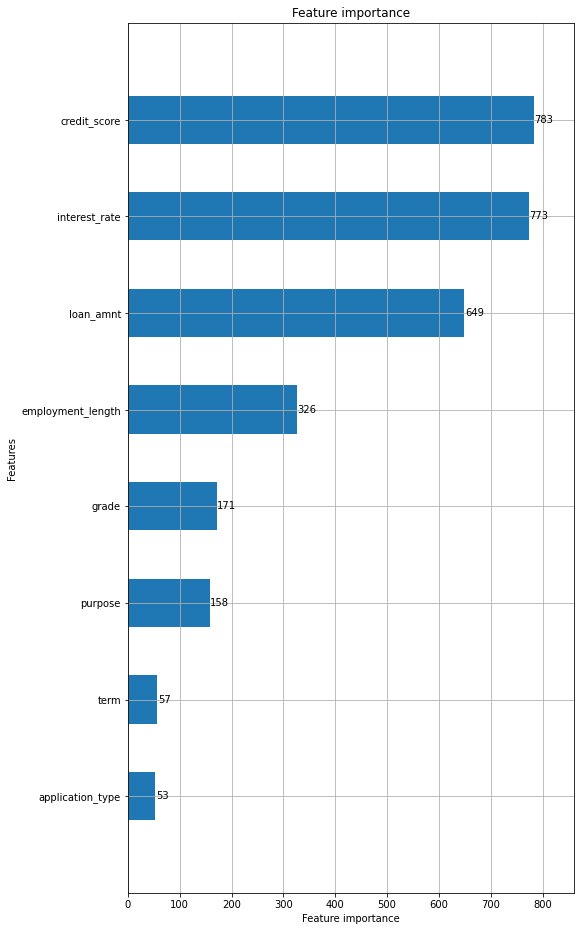

In [117]:
lgb.plot_importance(model, height=0.5, figsize=(8,16))

In [229]:
y_pred = np.where(y_pred_prob < 0.5, 0, 1)
# 真値と予測値の表示
df_pred = pd.DataFrame({'target':y_valid,'target_pred':y_pred})
display(df_pred)

# 真値と予測確率の表示
df_pred_prob = pd.DataFrame({'target':y_valid, 'target_prob':y_pred_prob})
display(df_pred_prob)

,target,target_pred
40551,1,1
103045,1,1
36102,1,1
48555,1,1
215561,1,1
...,...,...
62710,0,0
17907,1,1
90239,1,1
98682,1,1


,target,target_prob
40551,1,0.965233
103045,1,0.780544
36102,1,0.806072
48555,1,0.978094
215561,1,0.877089
...,...,...
62710,0,0.343157
17907,1,0.717954
90239,1,0.755884
98682,1,0.767033


In [237]:
acc = accuracy_score(y_valid,y_pred)
print('Acc :', acc)



ValueError: Classification metrics can't handle a mix of unknown and binary targets

In [231]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [232]:
y_valid

40551     1
103045    1
36102     1
48555     1
215561    1
         ..
62710     0
17907     1
90239     1
98682     1
14054     1
Name: loan_status, Length: 45403, dtype: object

In [ ]:
y_pred_prob= model.predict( X_test, num_iteration=model.best_iteration)

In [88]:
sample[1]= y_pred_prob 

In [89]:
sample.to_csv("submit.csv",index=None,header=None)